XGBoost


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime

# Load the keystreams and random streams
keystreams_df = pd.read_csv('4.csv')
random_streams_df = pd.read_csv('random_streams.csv')

keystreams = keystreams_df.values.tolist()
random_streams = random_streams_df.values.tolist()

# Generate labels
num_streams = len(keystreams)
labels_keystreams = [1] * num_streams
labels_random = [0] * num_streams

# Combine data and labels
combined_data = keystreams + random_streams
combined_labels = labels_keystreams + labels_random

# Create DataFrame
combined_df = pd.DataFrame(combined_data)
combined_df['label'] = combined_labels

# Split features and labels
X = combined_df.drop(columns=['label'])
y = combined_df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Start time before model
start_time = datetime.now()

# XGBoost classifier
model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Predictions and Accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# End time
end_time = datetime.now()
print(f"XGBoost Accuracy: {accuracy:.4f}")
print(f"Time Taken: {end_time - start_time}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:24:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.6210
Time Taken: 0:01:04.850716


Transformer Model


Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 152ms/step - accuracy: 0.5035 - loss: 0.6932 - val_accuracy: 0.4944 - val_loss: 0.6932
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.5008 - loss: 0.6932 - val_accuracy: 0.4944 - val_loss: 0.6932
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 149ms/step - accuracy: 0.4970 - loss: 0.6932 - val_accuracy: 0.4944 - val_loss: 0.6932
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step - accuracy: 0.5017 - loss: 0.6932 - val_accuracy: 0.4944 - val_loss: 0.6932
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.5077 - loss: 0.6931 - val_accuracy: 0.4944 - val_loss: 0.6932
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step
Transformer Accuracy: 0.4953
Time Taken: 0:03:24.938270


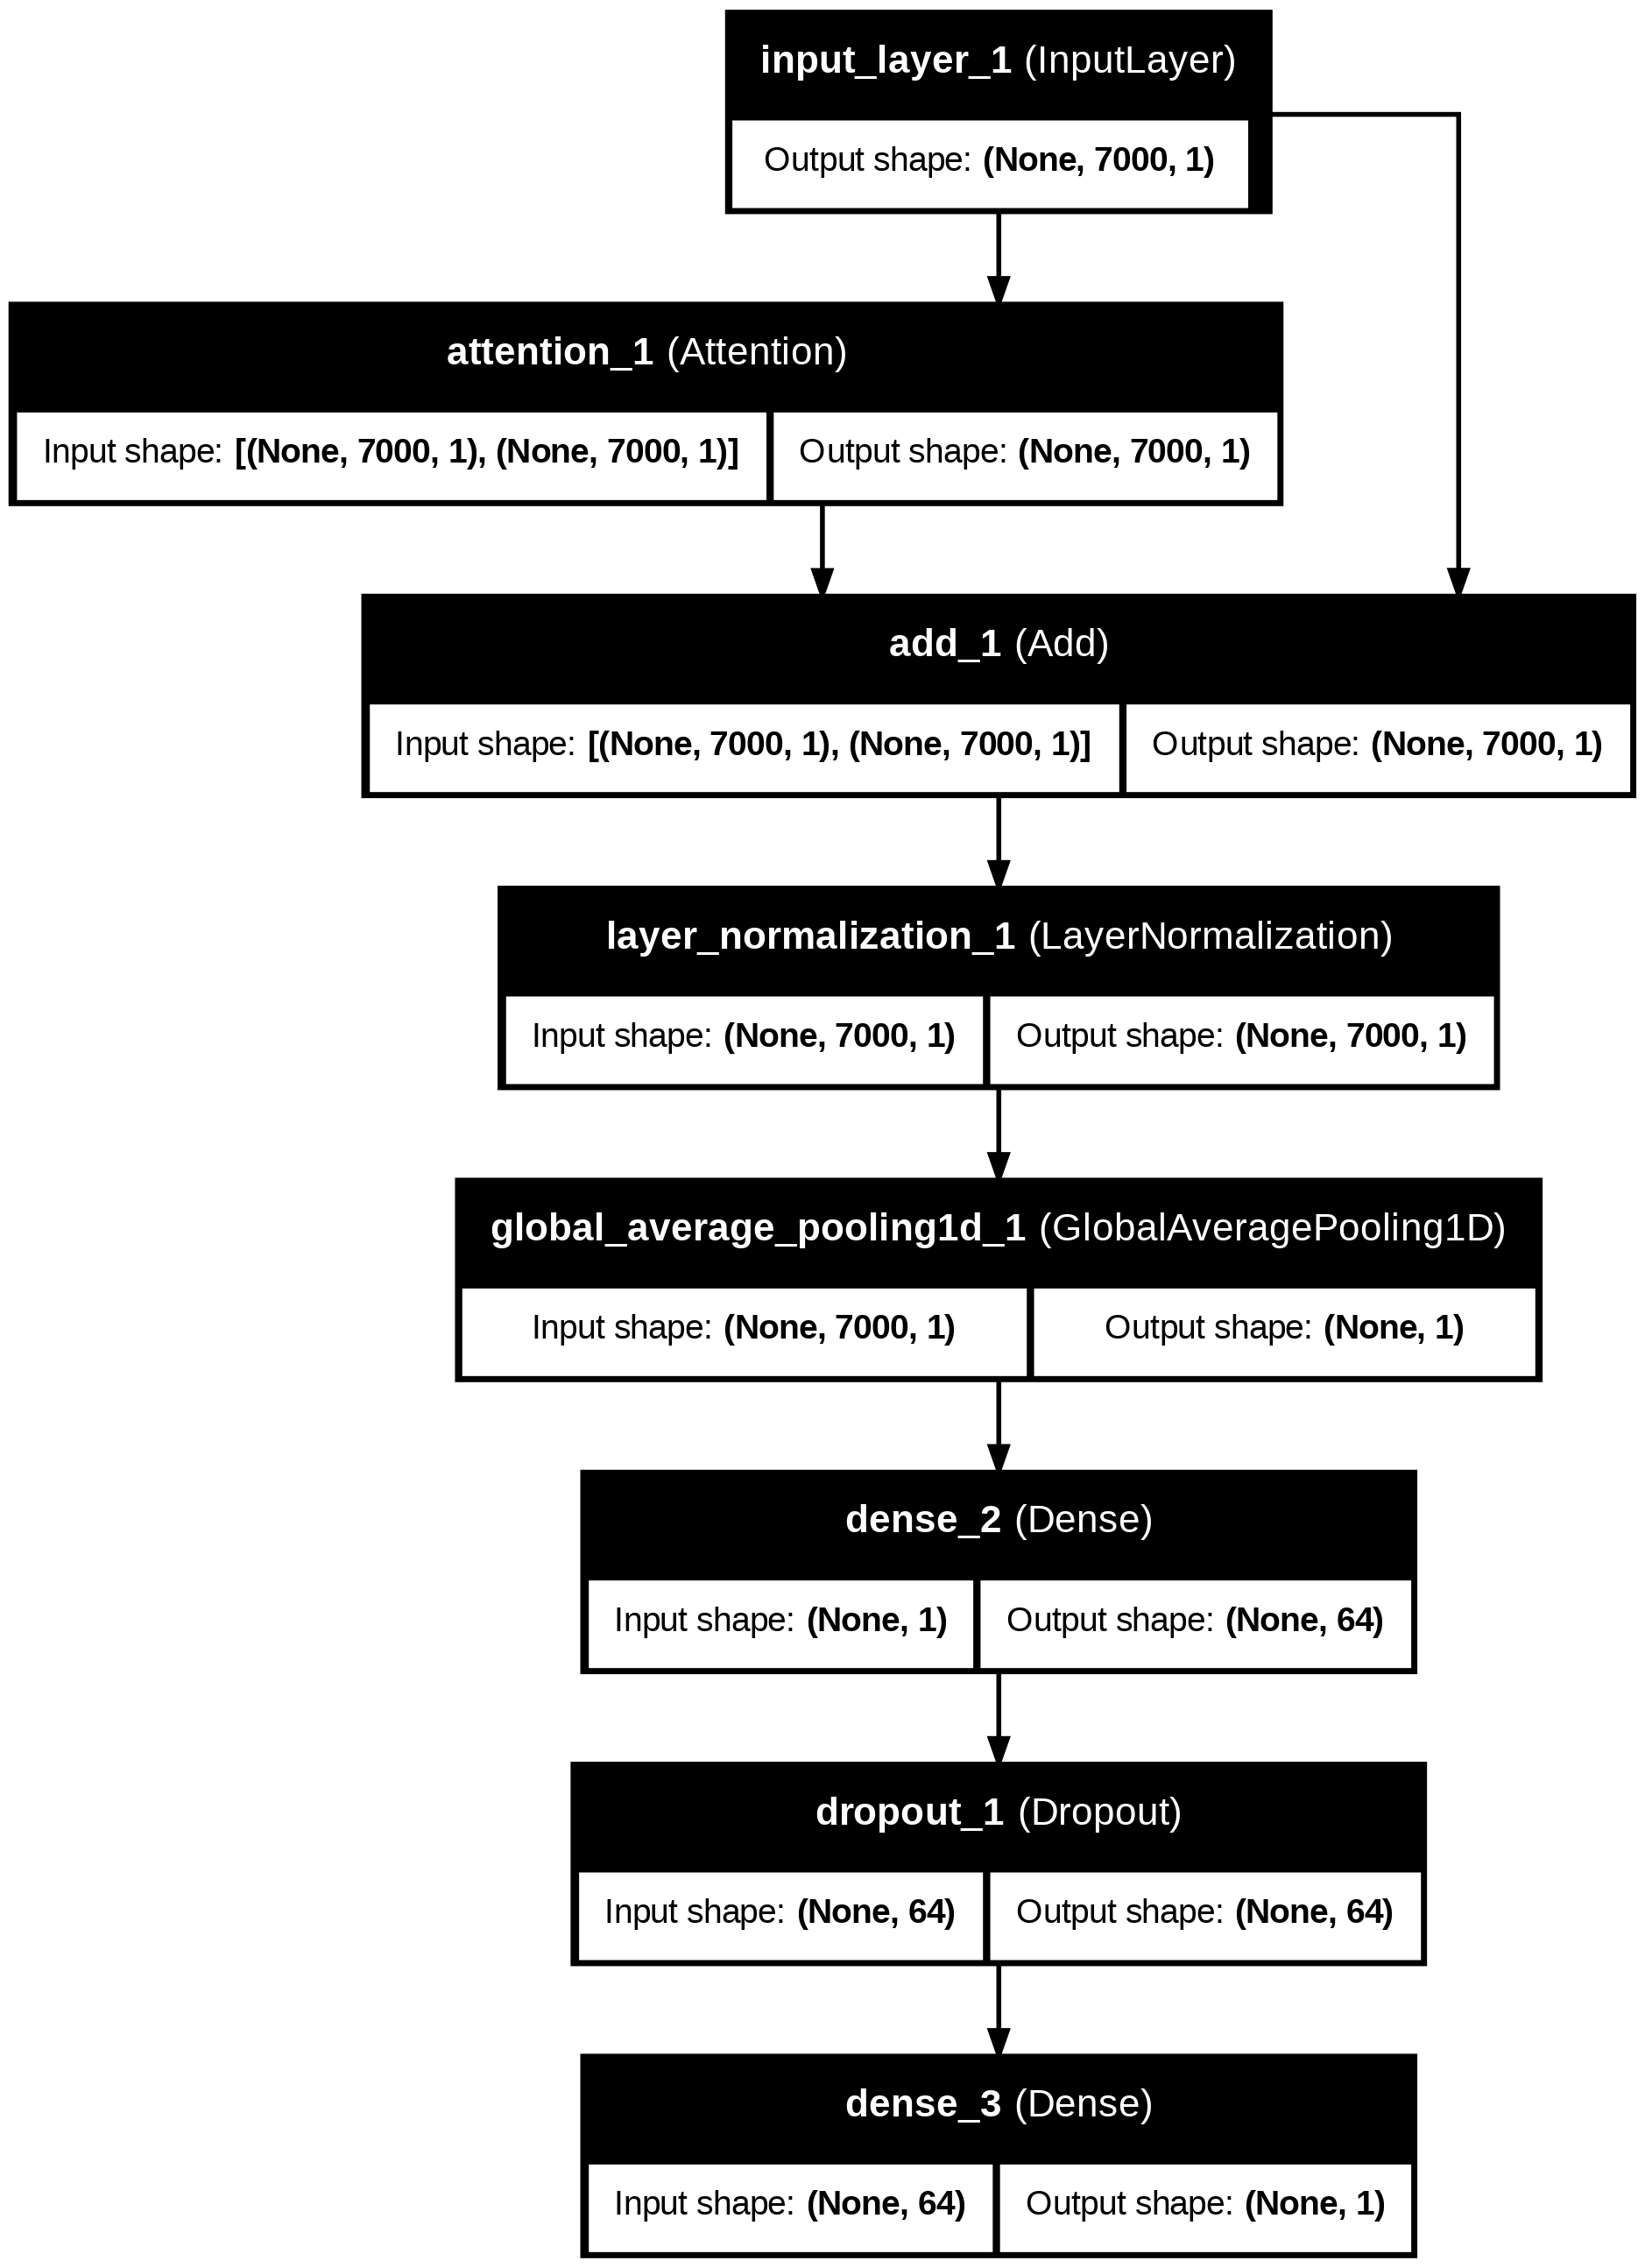

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
from tensorflow.keras.utils import plot_model
from IPython.display import Image
!pip install pydot graphviz

# Load data
keystreams = pd.read_csv('4.csv').values
random_streams = pd.read_csv('random_streams.csv').values

# Labels
num_samples = len(keystreams)
labels_keystreams = [1] * num_samples
labels_random = [0] * num_samples

# Combine
X = np.vstack((keystreams, random_streams)).astype(np.float32)
y = np.array(labels_keystreams + labels_random)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add channel dimension for attention input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Define Transformer-like model
def build_simple_transformer(seq_len):
    inputs = tf.keras.Input(shape=(seq_len, 1))
    attention = tf.keras.layers.Attention()([inputs, inputs])
    x = tf.keras.layers.Add()([inputs, attention])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs)

# Start time before model
start_time = datetime.now()

# Build and compile model
model = build_simple_transformer(seq_len=X_train.shape[1])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Predict and Evaluate
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)
acc = accuracy_score(y_test, y_pred)

# End time
end_time = datetime.now()
print(f"Transformer Accuracy: {acc:.4f}")
print(f"Time Taken: {end_time - start_time}")

# Generate and display model flowchart
plot_model(model, to_file='transformer_model.png', show_shapes=True, show_layer_names=True)
Image(filename='transformer_model.png')